### 1. Purpose of this notebook

The purpose of this notebook is to create a predictive model to classify customers and allow the company to maximize profit from the next marketing campaign.

> Predictive model 
- We used two models to try to predict the classification, decision tree and logistic regression. Logistic regression proved to be better, being more accurate in the true positives.

> Predictor variables
- We chose the predictor variables from the exploratory analysis (EDA) and after several tests.

> Model's metrics
- We adopted AUC as the main metric for the model. In our case, in which we have an imbalance of results (more True than False), it is more important to us
consider the consumer to be false when it is true, than to consider it to be true when it is false (thus preventing further loss of investment). Although the AUC of the logistic regression was around 0.83, in the executions we made there was a variation of about 0.1 (0.73 - 0.83).

#### Results

With the logistic regression model we can predict which customers are most probability to buy the gadget. However, by favoring a better success rate, we have a smaller number of customers.

We made a suggestion of an approach where we not only take into account the success rate, but the profit. We built a table where, based on the results of the model, we can define an acceptable probability (for example, 30%). Thus, for customers with more than 30% probability of buying the gadget, we will carry out the campaign. This allows us to send the campaign to more customers generating more cost, but also allowing for greater revenue.

### 2. Read data

#### 2.1 Import Python packages

In [1141]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

from src.paths import DATA
import src.eda as eda

%matplotlib inline
plt.style.use('bmh')
%load_ext autoreload
%autoreload 2

In [931]:
df = pd.read_csv(DATA / 'ml_project1_data_pre_processed.csv')
df_dummy_columns = pd.get_dummies(df[['Education','Marital_Status']])
df = pd.concat([df,df_dummy_columns], axis=1)
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Education_Master,Education_PhD,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,0,0,0,0,0,0,1,0,0,0
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,0,0,0,0,0,1,0,0,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,0,0,0,0,0,0,1,0,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,0,0,0,0,0,0,0,1,0,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0,1,0,0,0,1,0,0,0,0


### 3. Predictive model

In [932]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Response',
       'Z_Revenue_correct', 'Age', 'MntTotal', 'NumTotalPurchases',
       'AcceptedTotalFirstFiveCmps', 'AcceptedTotalFirstFiveCmpsMorePilot',
       'TotalYearAfterRegistration', 'TotalChildren', 'Education_2n Cycle',
       'Education_Basic', 'Education_Graduation', 'Education_Master',
       'Education_PhD', 'Marital_Status_Absurd', 'Marital_Status_Alone',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Together',
       'Marital_Status_Widow', 'Ma

#### 3.1 Customer behaviors used

We chose these products based on exploratory data analysis and tests performed here.

In [933]:
columns =['Recency', 'MntTotal', 'Income', 'Response','Education_2n Cycle',
       'Education_Master',
       'Education_PhD', 'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single',
       'AcceptedTotalFirstFiveCmps']

df = df[columns]

#removed outliers
df = df.query("Income < 118000")
df = df[df.Income.notnull()]

In [934]:
#Define train dataset
X_train, X_test, y_train, y_test = train_test_split(df.drop('Response',axis=1), df['Response'],test_size=0.3)

In [935]:
#size of datasets
[X_train.shape, X_test.shape,
y_train.shape, y_test.shape]

[(1542, 10), (661, 10), (1542,), (661,)]

#### 3.2 Definition of the best model

#### 3.2.1 Decision Tree

In [936]:
model1 = DecisionTreeClassifier()
model1 = model1.fit(X_train,y_train)

In [937]:
for feature, importancies in zip(df.drop('Response',axis=1), model1.feature_importances_):
    print(f"{feature}:{importancies:.3f}")

Recency:0.210
MntTotal:0.200
Income:0.263
Education_2n Cycle:0.011
Education_Master:0.009
Education_PhD:0.020
Marital_Status_Divorced:0.018
Marital_Status_Married:0.019
Marital_Status_Single:0.040
AcceptedTotalFirstFiveCmps:0.209


In [938]:
results_decision_tree = model1.predict(X_test)
print(metrics.classification_report(y_test, results_decision_tree))

              precision    recall  f1-score   support

       False       0.88      0.90      0.89       543
        True       0.47      0.42      0.44       118

    accuracy                           0.81       661
   macro avg       0.67      0.66      0.67       661
weighted avg       0.80      0.81      0.81       661



In [939]:
decision_tree_matrix = metrics.confusion_matrix(y_test, results_decision_tree)
decision_tree_matrix

array([[486,  57],
       [ 68,  50]], dtype=int64)

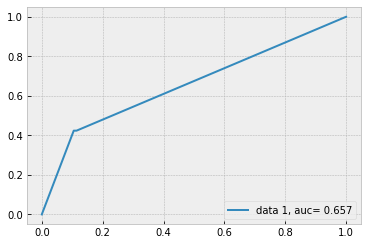

In [1153]:
y_pred_proba = model1.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"data 1, auc= {auc:.3f}")
plt.legend(loc=4)
plt.show()

The AUC value does not look very good and the precision in hitting true positives was below 0.50.

#### 3.2.2 Logistic Regression

In [941]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [942]:
results_logistic_regression = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.86


In [943]:
print(metrics.classification_report(y_test, results_logistic_regression))

              precision    recall  f1-score   support

       False       0.87      0.97      0.92       543
        True       0.74      0.33      0.46       118

    accuracy                           0.86       661
   macro avg       0.80      0.65      0.69       661
weighted avg       0.85      0.86      0.84       661



In [944]:
logistic_regression_matrix = metrics.confusion_matrix(y_test, results_logistic_regression)
logistic_regression_matrix

array([[529,  14],
       [ 79,  39]], dtype=int64)

In [945]:
print("Accuracy:", metrics.accuracy_score(y_test, results_logistic_regression).round(2))
print("Precision:", metrics.precision_score(y_test, results_logistic_regression).round(2))
print("Recall:", metrics.recall_score(y_test, results_logistic_regression).round(2))

Accuracy: 0.86
Precision: 0.74
Recall: 0.33


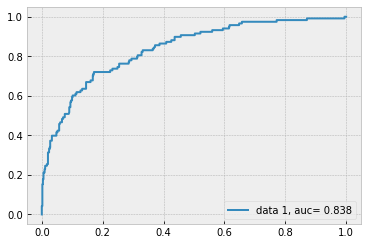

In [1154]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label=f"data 1, auc= {auc:.3f}")
plt.legend(loc=4)
plt.show()

The AUC value proved to be much better than in the decision tree. In addition, the accuracy in true positives was 0.74.

### 4. Applying the model

Applying the model to the dataset we have, we obtain the following results:

In [947]:
df['prob_true'] = logreg.predict_proba(df[columns].drop('Response', axis=1))[:,1]
df['result_pred'] = df['prob_true'].apply(lambda x: True if x >= 0.5 else False)
df.sample(5)

,Recency,MntTotal,Income,Response,Education_2n Cycle,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,AcceptedTotalFirstFiveCmps,prob_true,result_pred
239,23,20,60182.0,False,1,0,0,0,0,1,0,0.061186,False
1456,9,546,64866.0,False,0,1,0,0,0,0,1,0.337600,False
840,61,262,40049.0,False,0,0,0,0,1,0,0,0.036205,False
2094,40,39,53204.0,False,0,1,0,0,1,0,0,0.028673,False
1299,48,261,44267.0,False,0,0,0,1,0,0,0,0.068344,False


result_pred    147
Response       104
dtype: int64

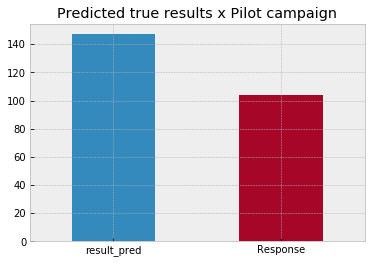

In [976]:
(df.query("result_pred == 1")[['result_pred','Response']]
 .sum()
 .plot
 .bar())
plt.title("Predicted true results x Pilot campaign")
plt.xticks(rotation=0);

df.query("result_pred == 1")[['result_pred','Response']].sum()

The model predicted that 147 customers would buy the gadget, however, looking at the responses we got in the pilot campaign, only 104 would actually buy.
This would give us a 70% success rate - better than the pilot's 15%. In terms of financial results, we would have a revenue of 1144 and a cost of 441 (profit of 703).

But, we have a problem: despite the good result in the success rate, we have a few customers. We can lower the probability limit by setting True or False (which is currently 0.5):

In [1161]:
df['result_pred_30p'] = df['prob_true'].apply(lambda x: True if x >= 0.30 else False)
df.sample(5)

,Recency,MntTotal,Income,Response,Education_2n Cycle,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,AcceptedTotalFirstFiveCmps,prob_true,result_pred,result_pred_30p,result_p
772,22,69,33622.0,False,0,0,0,0,1,0,0,0.098719,False,False,False
591,25,2066,92163.0,True,0,1,0,0,1,0,2,0.713415,True,True,False
2168,2,1914,79174.0,True,0,0,1,0,1,0,2,0.889761,True,True,False
1275,36,335,46149.0,False,0,0,0,0,1,0,0,0.062149,False,False,False
638,53,1408,63120.0,True,0,1,0,1,0,0,0,0.108595,False,False,False


result_pred_30p    358
Response           187
dtype: int64

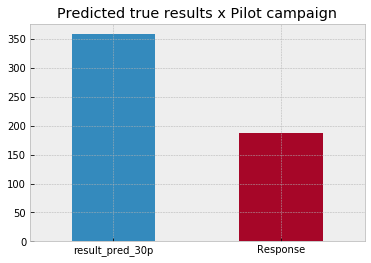

In [1131]:
(df.query("result_pred_30p == 1")[['result_pred_30p','Response']]
 .sum()
 .plot
 .bar())
plt.title("Predicted true results x Pilot campaign")
plt.xticks(rotation=0);

df.query("result_pred_30p == 1")[['result_pred_30p','Response']].sum()

Now, we have 52% success rate - better than the pilot's 15%. In terms of financial results, we would have a revenue of 1144 and a cost of 2057 (profit of 913).

As a suggestion, let's create a table containing the probability limits for True or False between 0 and 1. This way, we will know which probability value that optimizes the profit.

#### 4.1 Profit optimization

In [1166]:
eda.optimal_probability(df).head(40)

,limit_prob,result_pred,response,revenue_previst,cost_previst,profit_previst,tx_sucess
24,24,358,187,2057,1074,983,0.5
23,23,374,191,2101,1122,979,0.5
22,22,403,198,2178,1209,969,0.5
25,25,346,182,2002,1038,964,0.5
29,29,294,167,1837,882,955,0.6
21,21,423,202,2222,1269,953,0.5
28,28,304,169,1859,912,947,0.6
20,20,448,208,2288,1344,944,0.5
26,26,328,175,1925,984,941,0.5
27,27,316,171,1881,948,933,0.5


The table shows us that if we accepted all customers with a probability greater than 0.24 as True, we would have a 50% success rate (even greater than 15% of the pilot) and an expected profit of 983.